In [18]:
# Compute and get alpha map
import os
import time
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
from subprocess import DEVNULL, STDOUT, check_call
import numpy as np
import xml.dom.minidom as md

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

output_folder = 'images'
ref_output_folder = 'images/references'
mitsuba_binary = './../build-mis/mitsuba'
os.makedirs(ref_output_folder, exist_ok=True)

In [19]:
def convert_img(im):
    im_gamma_correct = np.clip(np.power(im, 0.45), 0, 1)
    im_fixed = Image.fromarray(np.uint8(im_gamma_correct*255))
    
    return np.array(im_fixed)

def update_mis_scene(scene_path, mis_method):
    file = md.parse(scene_path) 
    scene = file.getElementsByTagName("scene")
    defaults = scene[0].getElementsByTagName("default")

    mis_param = [ param for param in defaults if param.attributes['name'].value == 'mis' ][0]
    
    if mis_param is None:
        raise Exception(f"MIS key not found in {scene_path}")
    mis_param.setAttribute('value', mis_method)

    with open(scene_path, "w") as xml_file:
        file.writexml(xml_file)
        
def update_spp_scene(scene_path, spp):
    file = md.parse(scene_path) 
    scene = file.getElementsByTagName("scene")
    defaults = scene[0].getElementsByTagName("default")

    spp_param = [ param for param in defaults if param.attributes['name'].value == 'spp' ][0]
    spp_param.setAttribute('value', spp)

    with open(scene_path, "w") as xml_file:
        file.writexml(xml_file)

def read_exr(exr_path):
    image = np.array(cv2.imread(exr_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = convert_img(image)
    
    return image

def merge_exr(exr_paths):
    
    exr_images = [ np.array(cv2.imread(p, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)) for p in exr_paths ]
    final_image = np.mean(exr_images, axis=0)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    final_image = convert_img(final_image)
    
    return final_image

def get_diff(im1, im2):
    
    im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    return np.abs(np.array(im1_gray) - np.array(im2_gray))

def read_alpha_map(alpha_map_path):
    
    alpha_arr = []
    with open(alpha_map_path, 'r') as f:
        for line in f.readlines():
            pixel_line = line.split(';')
            pixels_channels = [ list(map(float, pixel.split(','))) for pixel in pixel_line ]
            alpha_arr.append(pixels_channels)
    return np.array(alpha_arr)

def read_pdfs_map(pdfs_map_path):
    
    pdfs_arr = []
    with open(pdfs_map_path, 'r') as f:
        for line in f.readlines():
            pixel_line = line.split(';')
            pixels_channels = [ list(map(str, pixel.split(','))) for pixel in pixel_line ]
            pixels_channels = [ np.asarray([ list(map(float, cc.split(' '))) for cc in c ]).flatten() for c in pixels_channels ]
            pdfs_arr.append(np.asarray(pixels_channels))
    return np.array(pdfs_arr)
        
def compute_methods(ref, scene_file, methods, output_name=None):
    
    fig, axes = plt.subplots(len(methods), 3, figsize=(18, 30))
    
    computed_images = {}
    for m_i, mis_method in enumerate(methods):
        
        _, scene_name = os.path.split(scene_file)
        scene_name = scene_name.replace('.xml', '')

        output_image_path = f"{output_folder}/{scene_name}_{mis_method}.exr"

        # update scene params
        update_mis_scene(scene_file, mis_method)
    
        # render and load image
        start = time.time()
        check_call([mitsuba_binary, '-t', '8', '-o', output_image_path, scene_file], stdout=DEVNULL, stderr=STDOUT)
        print(f'Rendering of method {mis_method} is done ({output_image_path})...')
        elapsed_time = time.time() - start
        # os.system(f'{mitsuba_binary} -t 8 -o {output_image_path} {scene_file}')
        
        image = read_exr(output_image_path)
        
        # read alpha map now
        alpha_map_path = output_image_path.replace('.exr', '.map')
        image_map = read_alpha_map(alpha_map_path)
        
        image_diff = get_diff(ref, image)
        
        axes[m_i][0].imshow(image)
        axes[m_i][0].set_title(f'{mis_method}: [rMSE: {np.sqrt(mse(ref, image)):.5f}, SSIM: {ssim(ref, image, channel_axis=2):.5f}]\nTime: {elapsed_time:.3f}')
        axes[m_i][0].axis('off')
        
        divider = make_axes_locatable(axes[m_i][1])
        ax_cb = divider.append_axes("right", size="2%", pad=0.02)
        fig = axes[m_i][1].get_figure()
        fig.add_axes(ax_cb)

        im = axes[m_i][1].imshow(image_map[:,:,0], cmap='RdBu', clim=(0, 1))
        axes[m_i][1].axis('off')
        
        plt.colorbar(im, cax=ax_cb)
        ax_cb.yaxis.tick_right()
        ax_cb.yaxis.set_tick_params(size=2)
        
        axes[m_i][2].imshow(image_diff, cmap='gray')
        axes[m_i][2].set_title(f'Visual error (from reference)')
        axes[m_i][2].axis('off')
        
        if mis_method not in computed_images:
            # tuple with image and alpha map
            computed_images[mis_method] = (image, image_map)
                
    # print(f'{mis_method}: [rMSE: {np.sqrt(mse(ref, image))}, SSIM: {ssim(ref, image, channel_axis=2)}]')
    if output_name is not None:
        plt.savefig(output_name, dpi=100)

In [20]:
# methods = ["balance", "power", "light", "bsdf", "tsallis", "linear1", "linear2", "linear3"]
methods = ["balance", "power", "light", "bsdf", "tsallis", "linear1", "linear2", "linear3"]

In [ ]:
ref_image_path = os.path.join(ref_output_folder, 'veach_no_background_power.exr')
scene_file = "scenes/veach-mis/veach_no_background.xml"
update_spp_scene(scene_file, '1000')
if not os.path.exists(ref_image_path):
    # os.system(f'{mitsuba_binary} -t 8 -o {ref_image_path} {scene_file}')
    check_call([mitsuba_binary, '-t', '4', '-o', ref_image_path, scene_file], stdout=DEVNULL, stderr=STDOUT)

ref = read_exr(ref_image_path)
# reset spp
update_spp_scene(scene_file, "100")
method_images = compute_methods(ref, scene_file, methods, 'images/mis_plot_no_background_variance.pdf')

Rendering of method balance is done (images/veach_balance.exr)...
Rendering of method power is done (images/veach_power.exr)...
Rendering of method light is done (images/veach_light.exr)...
Rendering of method bsdf is done (images/veach_bsdf.exr)...
Rendering of method tsallis is done (images/veach_tsallis.exr)...
Rendering of method linear1 is done (images/veach_linear1.exr)...
Rendering of method linear2 is done (images/veach_linear2.exr)...
Rendering of method linear3 is done (images/veach_linear3.exr)...


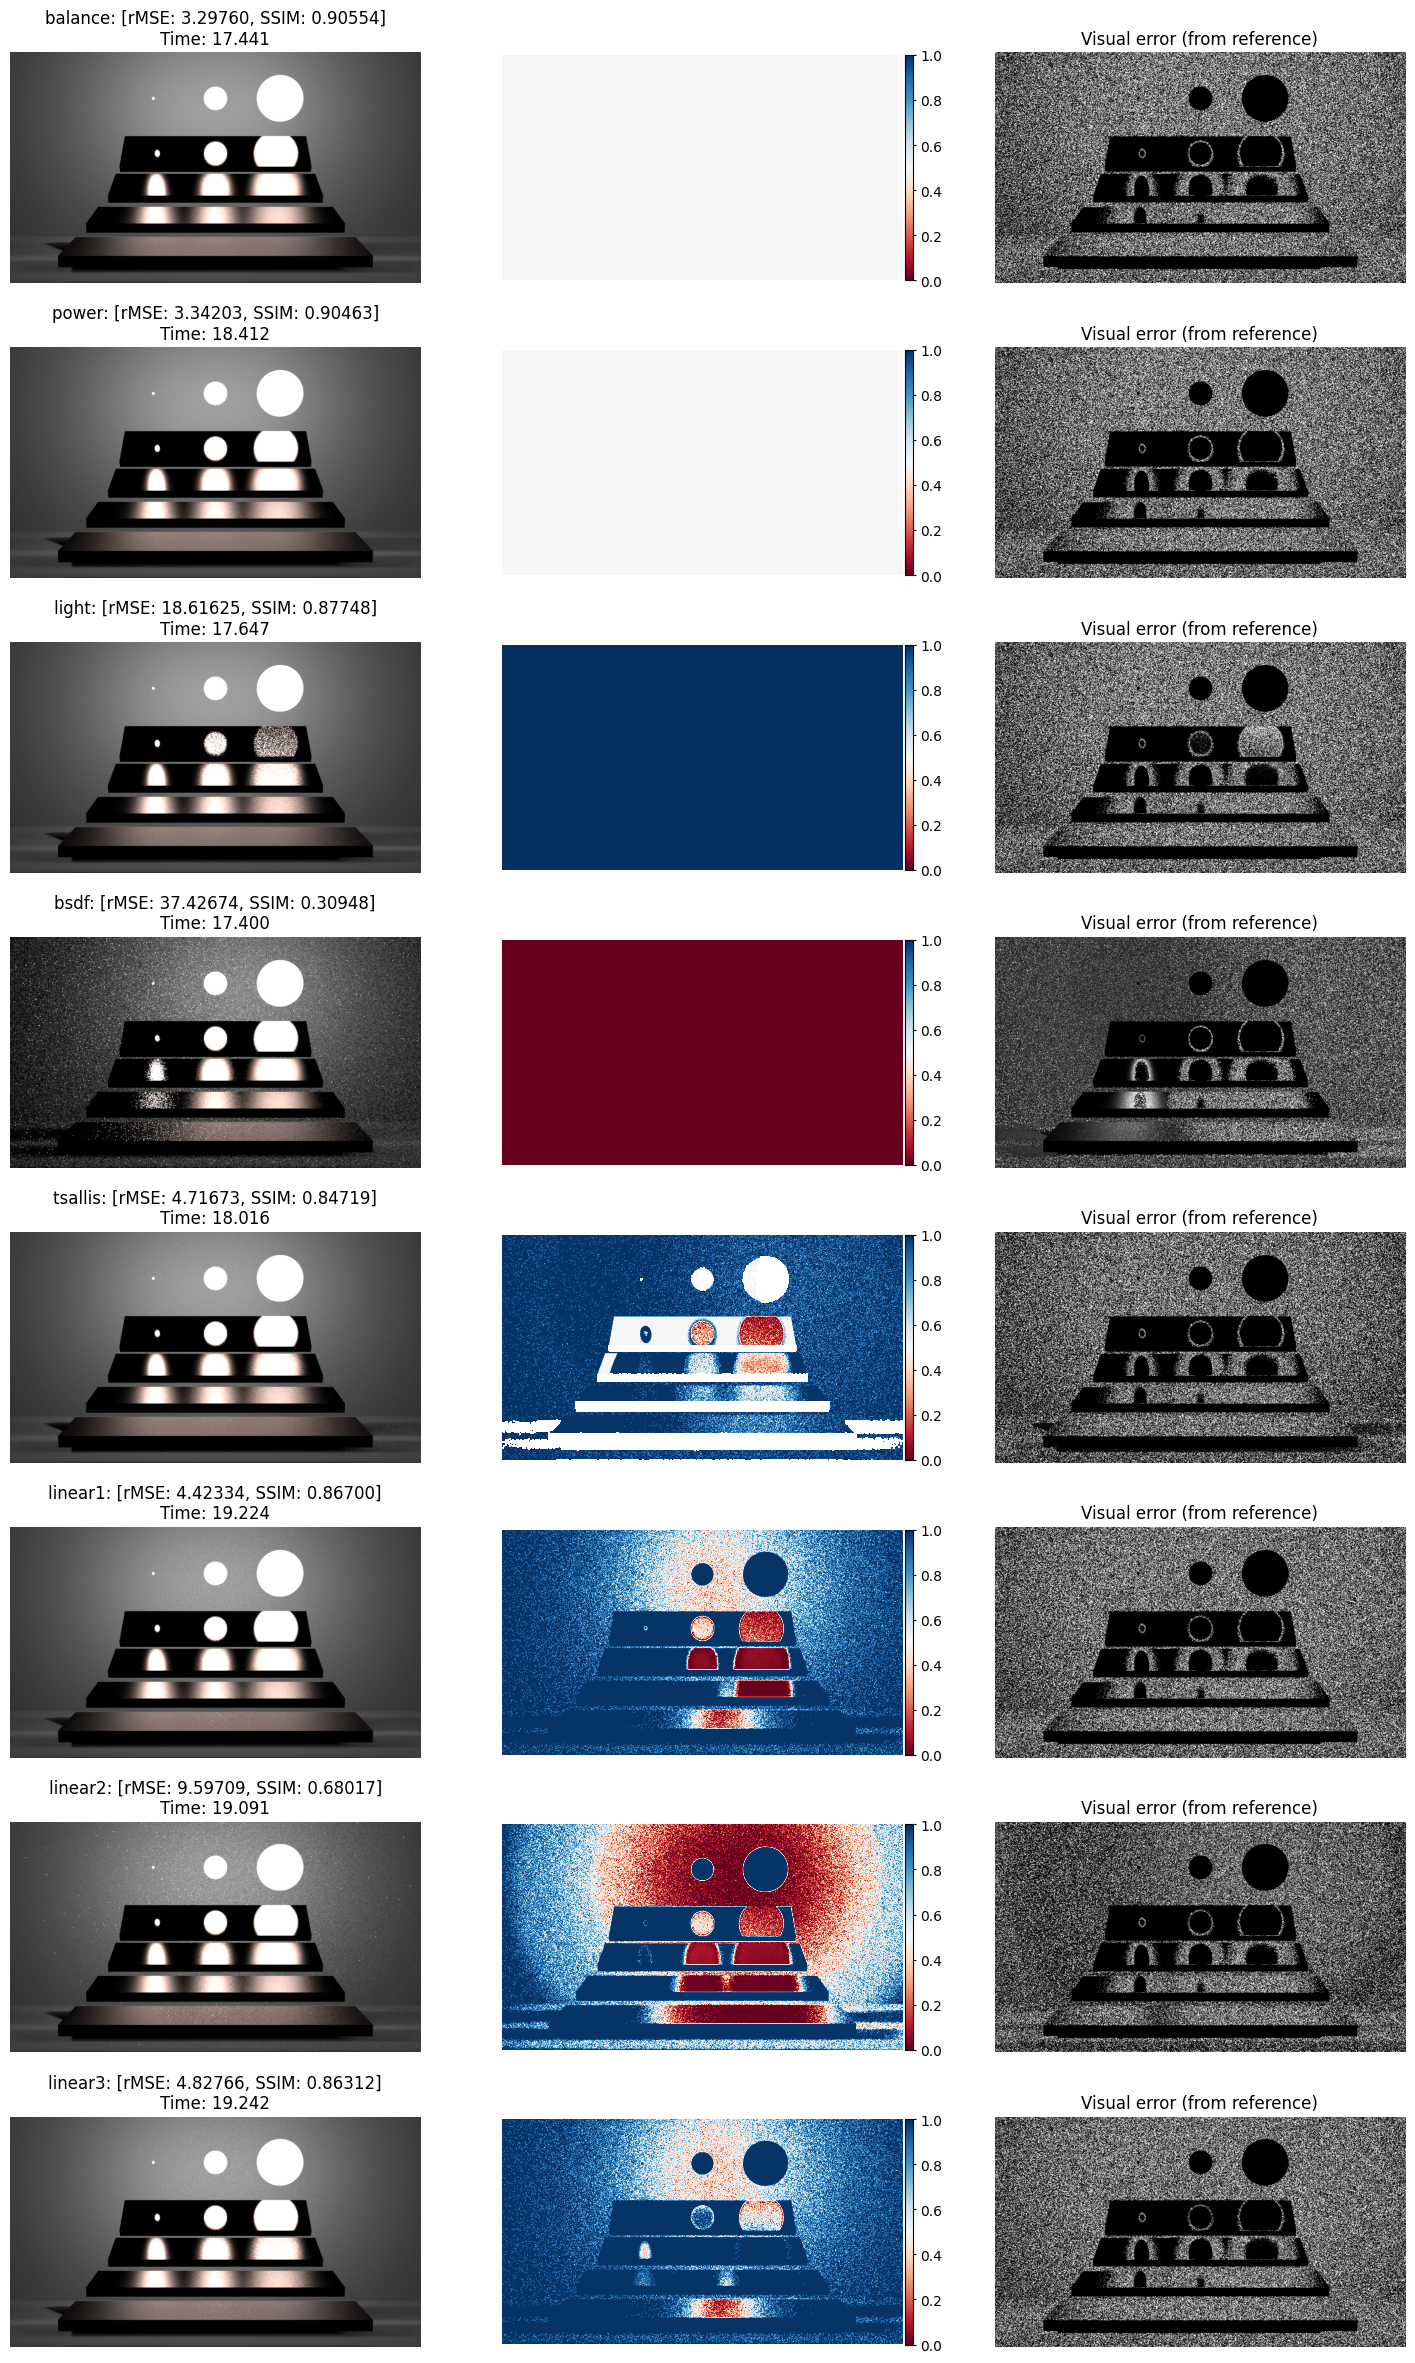

In [22]:
ref_image_path = os.path.join(ref_output_folder, 'veach_power.exr')
scene_file = "scenes/veach-mis/veach.xml"
update_spp_scene(scene_file, '1000')
if not os.path.exists(ref_image_path):
    # os.system(f'{mitsuba_binary} -t 8 -o {ref_image_path} {scene_file}')
    check_call([mitsuba_binary, '-t', '4', '-o', ref_image_path, scene_file], stdout=DEVNULL, stderr=STDOUT)

ref = read_exr(ref_image_path)
# reset spp
update_spp_scene(scene_file, "100")
method_images = compute_methods(ref, scene_file, methods, 'images/mis_plot_with_background_variance.pdf')

In [6]:
# try compare balance heuristic to: half BSDF + half ligth
# update scene params
#ref_image_path = os.path.join(ref_output_folder, 'veach_no_background_power.exr')
#scene_file = "scenes/veach-mis/veach_no_background.xml"
ref_image_path = os.path.join(ref_output_folder, 'veach_power.exr')
scene_file = "scenes/veach-mis/veach.xml"

In [7]:
# Display PDFs map from each sampling methods
scene_file = "scenes/veach-mis/veach.xml"
balance_path = 'images/balance_150.exr'
update_spp_scene(scene_file, "150")
update_mis_scene(scene_file, "balance")

# render and load image
start = time.time()
check_call([mitsuba_binary, '-t', '8', '-o', balance_path, scene_file], stdout=DEVNULL, stderr=STDOUT);
balance_time = time.time() - start

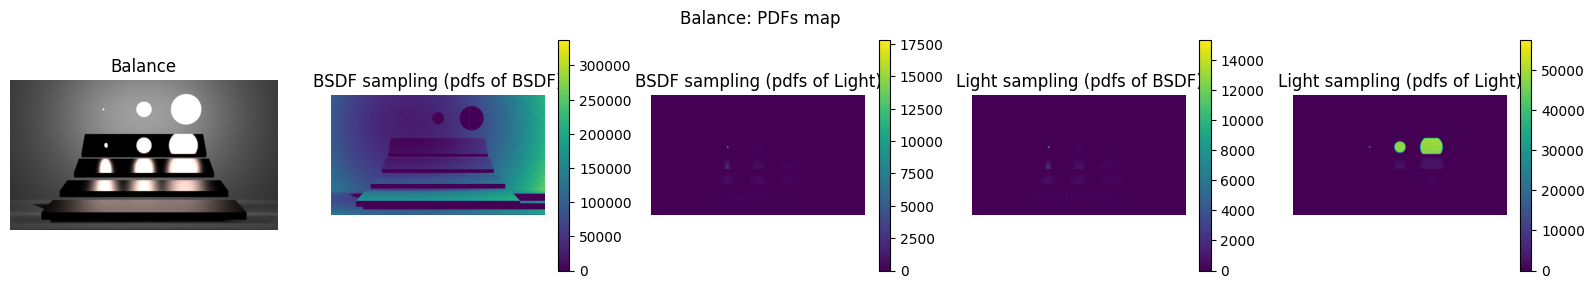

In [8]:
balance_img = read_exr(balance_path)
pdfs_data = read_pdfs_map(balance_path.replace('.exr', '_pdfs.map'))
fig, axes = plt.subplots(1, 5, figsize=(20, 3))

fig.suptitle('Balance: PDFs map')

axes[0].imshow(balance_img)
axes[0].set_title(f'Balance')
axes[0].axis('off');

pos = axes[1].imshow(pdfs_data[:,:,0])
fig.colorbar(pos, ax=axes[1])
axes[1].set_title(f'BSDF sampling (pdfs of BSDF)')
axes[1].axis('off');

pos = axes[2].imshow(pdfs_data[:,:,1])
fig.colorbar(pos, ax=axes[2])
axes[2].set_title(f'BSDF sampling (pdfs of Light)')
axes[2].axis('off');

pos = axes[3].imshow(pdfs_data[:,:,2])
fig.colorbar(pos, ax=axes[3])
axes[3].set_title(f'Light sampling (pdfs of BSDF)')
axes[3].axis('off');

pos = axes[4].imshow(pdfs_data[:,:,3])
fig.colorbar(pos, ax=axes[4])
axes[4].set_title(f'Light sampling (pdfs of Light)')
axes[4].axis('off');

#plt.savefig('balance_150_light_and_bsdf_300.pdf', dpi=100)

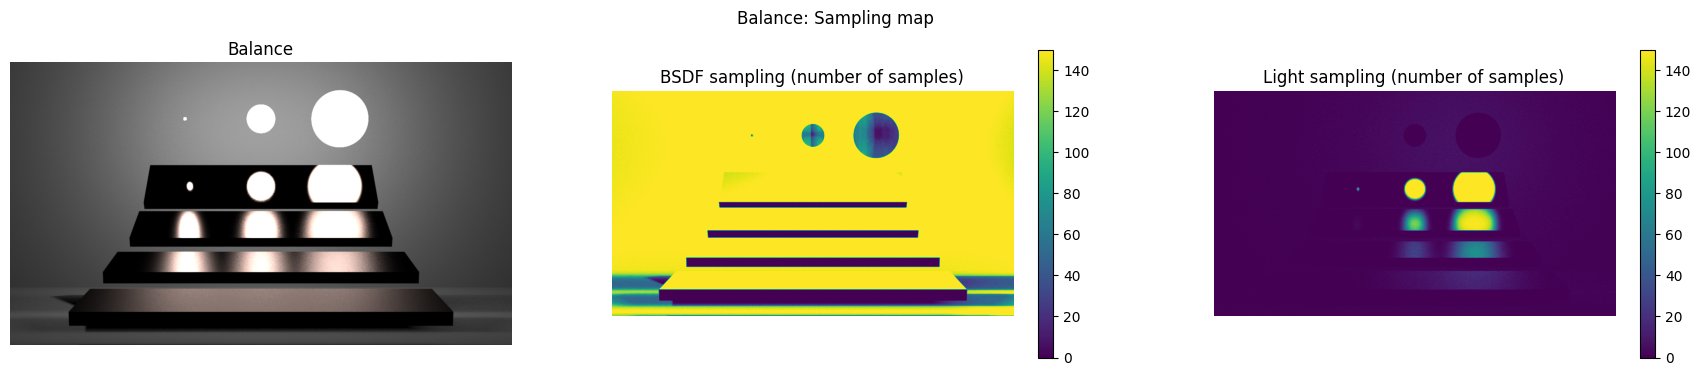

In [9]:
balance_img = read_exr(balance_path)
sampling_data = read_pdfs_map(balance_path.replace('.exr', '_samples.map'))

fig, axes = plt.subplots(1, 3, figsize=(22, 4))

fig.suptitle('Balance: Sampling map')

axes[0].imshow(balance_img)
axes[0].set_title(f'Balance')
axes[0].axis('off');

pos = axes[1].imshow(sampling_data[:,:,0])
axes[1].set_title(f'BSDF sampling (number of samples)')
fig.colorbar(pos, ax=axes[1])
axes[1].axis('off');

pos = axes[2].imshow(sampling_data[:,:,1])
axes[2].set_title(f'Light sampling (number of samples)')
fig.colorbar(pos, ax=axes[2])
axes[2].axis('off');
#plt.savefig('balance_150_light_and_bsdf_300.pdf', dpi=100)